Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-+.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-+.html
Using device: cuda
Starting training...


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 10/100
Loss: 1.8594
Test Accuracy: 0.3647
------------------------

Epoch 20/100
Loss: 1.6557
Test Accuracy: 0.3187
------------------------

Epoch 30/100
Loss: 1.6370
Test Accuracy: 0.3693
------------------------

Epoch 40/100
Loss: 1.6063
Test Accuracy: 0.3673
------------------------

Epoch 50/100
Loss: 1.5828
Test Accuracy: 0.4040
------------------------

Epoch 60/100
Loss: 1.5634
Test Accuracy: 0.4113
------------------------

Epoch 70/100
Loss: 1.5710
Test Accuracy: 0.4153
------------------------

Epoch 80/100
Loss: 1.5685
Test Accuracy: 0.4247
------------------------

Epoch 90/100
Loss: 1.5607
Test Accuracy: 0.4133
------------------------

Epoch 100/100
Loss: 1.5429
Test Accuracy: 0.4100
------------------------

Final Test Accuracy: 0.4100


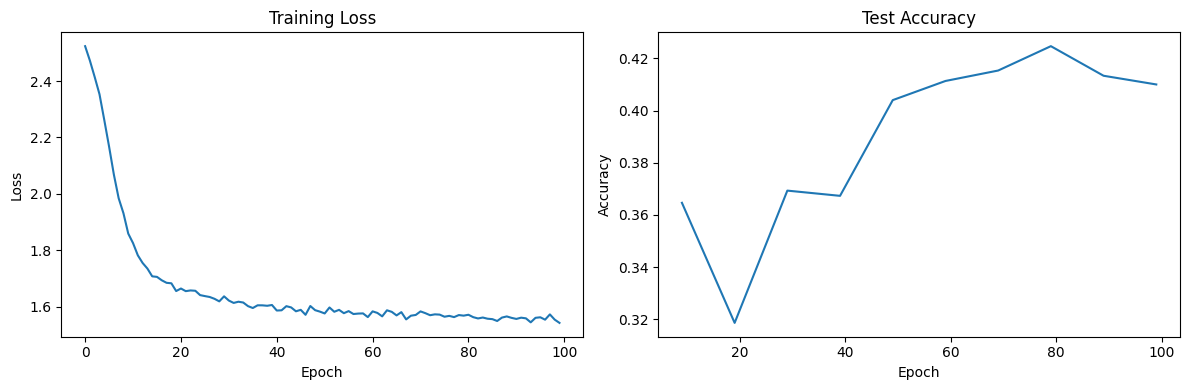

In [1]:
# Install required packages
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import k_hop_subgraph, to_undirected
import numpy as np
from torch.optim import Adam
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Set random seeds
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)
data.edge_index = to_undirected(data.edge_index)

class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, dropout=0.2):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(embedding_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        return x

class SubgraphContrastiveLearner(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, temperature=0.5):
        super(SubgraphContrastiveLearner, self).__init__()
        self.encoder = GCNEncoder(input_dim, hidden_dim, embedding_dim)
        self.temperature = temperature

    def forward(self, x, edge_index):
        return self.encoder(x, edge_index)

    def get_subgraph(self, node_idx, edge_index, x, num_hops=1):
        try:
            node_idx = torch.tensor([node_idx], device=edge_index.device)
            subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(
                node_idx,
                num_hops,
                edge_index,
                relabel_nodes=True,
                num_nodes=x.size(0)
            )

            # Handle isolated nodes
            if sub_edge_index.numel() == 0:
                sub_edge_index = torch.tensor([[0], [0]], device=edge_index.device)

            sub_x = x[subset]
            return sub_x, sub_edge_index, subset, mapping

        except Exception as e:
            print(f"Error in get_subgraph for node {node_idx}: {str(e)}")
            return (x[node_idx].unsqueeze(0),
                   torch.tensor([[0], [0]], device=edge_index.device),
                   node_idx.unsqueeze(0),
                   torch.tensor([0], device=edge_index.device))

    def info_nce_loss(self, anchor_features, pos_features, neg_features):
        anchor_features = F.normalize(anchor_features, dim=1)
        pos_features = F.normalize(pos_features, dim=1)
        neg_features = F.normalize(neg_features, dim=1)

        pos_sim = torch.exp(torch.sum(anchor_features * pos_features, dim=-1) / self.temperature)
        neg_sim = torch.exp(torch.matmul(anchor_features, neg_features.T) / self.temperature)

        loss = -torch.log(pos_sim / (pos_sim + neg_sim.sum(dim=1) + 1e-8))
        return loss.mean()

def create_subgraph_tasks(data, n_way=5, k_shot=5, n_query=15, n_tasks=100):
    tasks = []
    labels = data.y.unique()

    for _ in range(n_tasks):
        selected_classes = np.random.choice(labels.cpu(), n_way, replace=False)
        support_examples = []
        query_examples = []

        for cls in selected_classes:
            cls_indices = torch.where(data.y == cls)[0]
            k_shot_curr = min(k_shot, len(cls_indices) // 2)
            n_query_curr = min(n_query, len(cls_indices) - k_shot_curr)

            if k_shot_curr > 0 and n_query_curr > 0:
                selected_indices = np.random.choice(cls_indices.cpu(), k_shot_curr + n_query_curr, replace=False)
                support_examples.extend(selected_indices[:k_shot_curr].tolist())
                query_examples.extend(selected_indices[k_shot_curr:k_shot_curr + n_query_curr].tolist())

        if len(support_examples) > 0 and len(query_examples) > 0:
            tasks.append({
                'support': torch.tensor(support_examples, device=data.x.device),
                'query': torch.tensor(query_examples, device=data.x.device)
            })

    return tasks

def train_epoch(model, data, tasks, optimizer):
    model.train()
    epoch_loss = 0
    valid_tasks = 0

    for task in tasks:
        support_idx = task['support']
        query_idx = task['query']

        if len(support_idx) == 0 or len(query_idx) == 0:
            continue

        batch_loss = 0
        valid_queries = 0

        for q_idx in query_idx:
            try:
                # Get query node subgraph and embedding
                q_x, q_edge_index, q_subset, _ = model.get_subgraph(q_idx, data.edge_index, data.x)
                q_embeddings = model(q_x.to(device), q_edge_index.to(device))
                q_node_embedding = q_embeddings[0]

                # Get positive examples
                pos_indices = support_idx[data.y[support_idx] == data.y[q_idx]]
                if len(pos_indices) == 0:
                    continue

                pos_idx = random.choice(pos_indices.tolist())
                pos_x, pos_edge_index, pos_subset, _ = model.get_subgraph(pos_idx, data.edge_index, data.x)
                pos_embeddings = model(pos_x.to(device), pos_edge_index.to(device))
                pos_node_embedding = pos_embeddings[0]

                # Get negative examples
                neg_indices = support_idx[data.y[support_idx] != data.y[q_idx]]
                if len(neg_indices) == 0:
                    continue

                n_neg = min(len(neg_indices), 10)
                neg_idxs = np.random.choice(neg_indices.cpu(), n_neg, replace=False)

                neg_embeddings = []
                for neg_idx in neg_idxs:
                    neg_x, neg_edge_index, neg_subset, _ = model.get_subgraph(neg_idx, data.edge_index, data.x)
                    neg_emb = model(neg_x.to(device), neg_edge_index.to(device))[0]
                    neg_embeddings.append(neg_emb)

                if len(neg_embeddings) == 0:
                    continue

                neg_embeddings = torch.stack(neg_embeddings)

                loss = model.info_nce_loss(
                    q_node_embedding.unsqueeze(0),
                    pos_node_embedding.unsqueeze(0),
                    neg_embeddings
                )
                batch_loss += loss
                valid_queries += 1

            except Exception as e:
                continue

        if valid_queries > 0:
            batch_loss = batch_loss / valid_queries
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            epoch_loss += batch_loss.item()
            valid_tasks += 1

    return epoch_loss / max(1, valid_tasks)

def evaluate(model, data, test_tasks):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for task in test_tasks:
            support_idx = task['support']
            query_idx = task['query']

            if len(support_idx) == 0 or len(query_idx) == 0:
                continue

            support_embeddings = []
            support_labels = []

            for idx in support_idx:
                try:
                    s_x, s_edge_index, s_subset, _ = model.get_subgraph(idx, data.edge_index, data.x)
                    s_emb = model(s_x.to(device), s_edge_index.to(device))[0]
                    support_embeddings.append(s_emb)
                    support_labels.append(data.y[idx])
                except Exception as e:
                    continue

            if len(support_embeddings) == 0:
                continue

            support_embeddings = torch.stack(support_embeddings)
            support_labels = torch.tensor(support_labels, device=device)

            for q_idx in query_idx:
                try:
                    q_x, q_edge_index, q_subset, _ = model.get_subgraph(q_idx, data.edge_index, data.x)
                    q_emb = model(q_x.to(device), q_edge_index.to(device))[0]

                    similarities = F.cosine_similarity(q_emb.unsqueeze(0), support_embeddings)
                    pred_idx = similarities.argmax()
                    pred_label = support_labels[pred_idx]

                    correct += (pred_label == data.y[q_idx]).item()
                    total += 1
                except Exception as e:
                    continue

    return correct / max(1, total)

# Training configuration
config = {
    'input_dim': dataset.num_features,
    'hidden_dim': 256,
    'embedding_dim': 128,
    'n_epochs': 100,
    'learning_rate': 0.001,
    'n_way': 5,
    'k_shot': 3,
    'n_query': 15,
    'n_train_tasks': 100,
    'n_test_tasks': 20
}

# Initialize model and optimizer
model = SubgraphContrastiveLearner(
    config['input_dim'],
    config['hidden_dim'],
    config['embedding_dim']
).to(device)

optimizer = Adam(model.parameters(), lr=config['learning_rate'])

# Create meta-learning tasks
train_tasks = create_subgraph_tasks(
    data,
    n_way=config['n_way'],
    k_shot=config['k_shot'],
    n_query=config['n_query'],
    n_tasks=config['n_train_tasks']
)

test_tasks = create_subgraph_tasks(
    data,
    n_way=config['n_way'],
    k_shot=config['k_shot'],
    n_query=config['n_query'],
    n_tasks=config['n_test_tasks']
)

# Training history
history = {
    'train_loss': [],
    'test_accuracy': []
}

# Training loop
print("Starting training...")
for epoch in tqdm(range(config['n_epochs'])):
    loss = train_epoch(model, data, train_tasks, optimizer)
    history['train_loss'].append(loss)

    if (epoch + 1) % 10 == 0:
        accuracy = evaluate(model, data, test_tasks)
        history['test_accuracy'].append(accuracy)
        print(f"\nEpoch {epoch+1}/{config['n_epochs']}")
        print(f"Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print("------------------------")

# Final evaluation
final_accuracy = evaluate(model, data, test_tasks)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(9, config['n_epochs'], 10), history['test_accuracy'])
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
plt.savefig('5_way_3_shot.png')

# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': config,
    'history': history,
}, 'cora_subgraph_meta_learning_checkpoint.pt')